In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt#
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# BREP original output evaluation

This notebook was used to investigate in the files that the original BREP program produces. 
In the first part, data that has been used in the original simulation is investigated.
The second part deals more with smaller aspects and data that was used by running the scheme BREP locally and on a smaller dataset.
Related investigations have been done in other files as well:
- In the Golgi_cell_checkout notebook, the rendering of Golgi cells is analysed and reproduced, and some analysiy on the Golgi-Golgi connections is performed
- The BREPpy_first notebook contains several investigations, mostly with a focus of single connections
- The Test_Code notebook contains functions to investigate in new code that are sometimes based on functions from this file. Also, it contains some of the plots from this file, generated for pyBREP results.


##  Data that has been used in an example simulation

### Utlls

In [25]:
''' this cell is basically the python 3 version of the nrnvector file'''
import struct
import numpy as np
from tqdm import tqdm

type_length = {3: 4, # FLOAT
               4: 8, # #DOUBLE
               5: 4}  # INT

type_name = {3: 'float', # FLOAT
             4: 'double', # #DOUBLE
             5: 'int'}  # INT


def get_all_data_size(filename):
    n = 0
    ncell = 0
    ntype = None
    with open(filename, 'rb') as f:
        try:
            x = f.read(8) #read two integers
            on = True
        except:
            raise Exception('What!')

        while on:
            try:
                n1, ntype = struct.unpack('<ii', x) # read two integers
                n += n1 - 1 # subtract 1 from the cell index
                ncell += 1
                f.seek(n1*type_length[ntype], 1)
                x = f.read(8) # read two integers again
            except:
                f.close()
                on = False
        return (n, ncell, ntype)


def read_neuron_vectors(filename, data_size):
    ndata, ncell, ntype = data_size
    data = np.empty(ndata, dtype=type_name[ntype])
    cell = np.empty(ndata, dtype=int)

    count = 0
    mincell = ncell*100
    maxcell = 1
    with open(filename, 'rb') as f:
        for _ in tqdm(range(ncell)):
            x = f.read(8)
            n, ntype = struct.unpack('<ii', x)
            x = f.read(n*type_length[ntype])
            if n>1:
                st = np.fromstring(x, dtype=type_name[ntype])
                data[count:(count+n-1)] = st[1:]
                cell[count:(count+n-1)] = st[0]
                count = count + n-1
            else:
                st = np.fromstring(x, dtype=type_name[ntype])
            if mincell>st[0]:
                mincell = st[0]
            if maxcell<st[0]:
                maxcell = st[0]
        # print mincell, maxcell
    return (data, cell, int(mincell)-1)

def count_pre(post):
    "count_pre counts the number of presynaptic cells converging to each postsynaptic cell"
    cells = np.sort(np.unique(post))
    return cells, np.array([(post==c).sum() for c in cells])

def con_per_cell (ref, n_cells):
    '''Finds the occurence of each number from 0 to n_cell-1 in ref
    -> if ref contains source or target IDs, it is the number of connections for each ID'''
    cs, c_counts = np.unique(ref, return_counts = True)
    real_ccs = np.zeros(n_cells)
    for i, c in enumerate( cs):
        real_ccs[int(c-1)]
        real_ccs[int(c-1)] = c_counts[i]
    return real_ccs

### Data read-in

In [3]:
#read in data
filename = 'example_simulation/data/PFtoGoC.bin'
dsize = get_all_data_size(filename) # first we read the data size (number of cells, etc.)
pfs, gocs, _ = read_neuron_vectors(filename, dsize) # and read the data
pfs = pfs.astype(int)
#convert the global indices to regular indices
pfs = pfs-min(pfs)
gocs = gocs-min(gocs)

100%|██████████| 1995/1995 [00:01<00:00, 1547.47it/s]


In [15]:
#read in population files the complicated way...
p1 = './example_simulation/coordinates_input/'
go_ori = p1+'GoCcoordinates.sorted.dat'
gr_ori = p1+'GCcoordinates.sorted.dat'
%run BREPpy.py
cp = Cell_pop('d')
cp.read_in_soma_file(go_ori)
go_s = cp.som
cp.read_in_soma_file(gr_ori)
gr_s = cp.som

1995


### Connectivity histograms

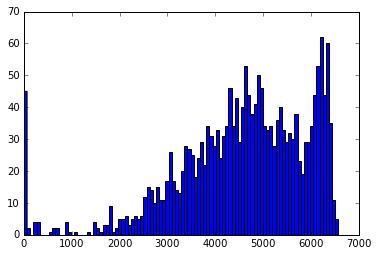

In [16]:
#histogram for Golgi cells
c_gol = con_per_cell (gocs, len(go_s))
_ = plt.hist(c_gol,100)

797999 0
798000


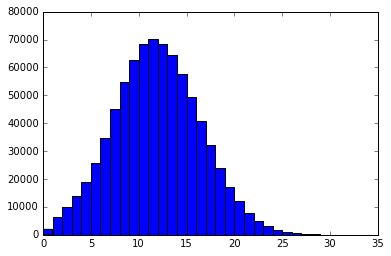

In [19]:
#histogram for Granule cells
c_pf = con_per_cell (pfs, len(gr_s)) 
plt.figure()
_ = plt.hist(c_pf, int(max(c_pf)))

### Spatial differences in connectivity

In [20]:
real_ccs = c_gol
norm = mpl.colors.Normalize(vmin=0, vmax=max(real_ccs))
cmap = cm.plasma
m = cm.ScalarMappable(norm=norm, cmap=cmap)
rgb = m.to_rgba(real_ccs)
print (rgb.shape)

(1995, 4)


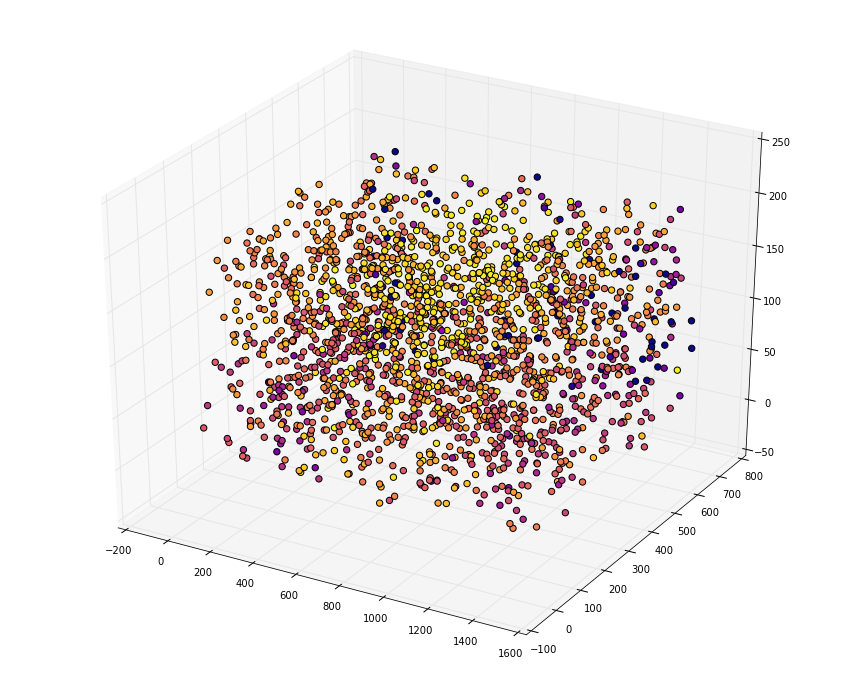

In [21]:
fig = plt.figure(figsize = (15,12))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(go_s[:,0], go_s[:,1], go_s[:,2], depthshade = False, facecolors = rgb, s  = 40)
plt.show()

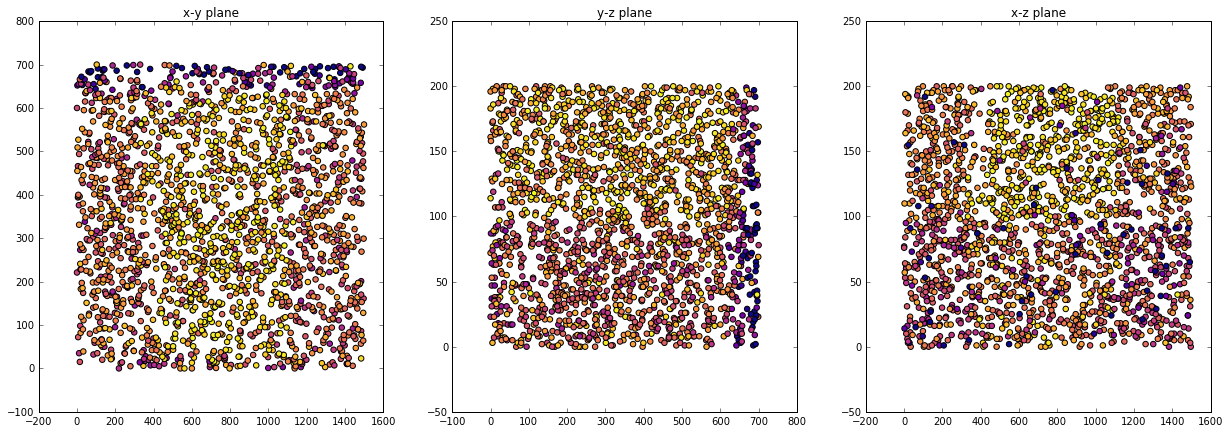

In [24]:
#2D projections
s_val = np.sort(real_ccs)
p10 = int(len(s_val)/10)
idx_top10 = real_ccs>s_val[9*p10]
idx_bot10 = real_ccs<s_val[p10]
idx_all = np.arange(len(s_val)-1)
idx_0  = real_ccs == 0


cur_idx = idx_all

plt.figure(figsize=(21,7))
for i, [j, k, tit] in enumerate([[0,1, 'x-y plane'], [1,2, 'y-z plane'], [0,2, 'x-z plane']]):
    
    plt.subplot(1,3,i+1)
    
    plt.scatter(go_s[cur_idx,j], go_s[cur_idx,k], facecolors = rgb[cur_idx], s  = 30)
    #plt.axis('equal')
    
    if False:
        if i in [0,2]: plt.xlim([-100, 500])
    plt.title (tit)

## Data produced by local original BREP

### Load data and get overview

In [28]:
import csv
def read_in_coordfile (fn, parse_ignore = True):
    '''
    reads in the file stored under fn (works for certain files that contain coordinates)
    Returns a np array with the data.
    If there is a problem parsing, this function will not break, however it will store it in a dict 
    If parse-ignore is set False, the number of unparsable signs as well as a set of them will be printed.
    '''
    res = []
    with open (fn, newline = '') as f:
        rr = csv.reader(f, delimiter = ' ')
        err = []
        for line in rr:
            ar = []
            for j in range(len(line)):
                try: ar.append(float(line[j]))
                except: err.append(line[j])
            res.append(np.asarray(ar))
    if len(err)> 0 and not parse_ignore: print ('Could not parse on {} instances: {}'.format(len(err), set(err)))
    return np.asarray(res)

src_ori = read_in_coordfile('output_brep/output_16/AAtoGoCsources.dat')
src_fake = read_in_coordfile('output_pybrep/testingAAtoGoCsources0.dat')
tar_ori =  read_in_coordfile('output_brep/output_16/AAtoGoCtargets.dat')
tar_fake = read_in_coordfile('output_pybrep/testingAAtoGoCtargets0.dat')

goco_f = read_in_coordfile('example_simulation/coordinates_input/subsampled/GoCcoordinates_64.dat')
grco_f = read_in_coordfile('example_simulation/coordinates_input/subsampled/GCcoordinates_64.dat')


In [30]:
for f in [src_ori, src_fake, tar_ori, tar_fake]:
    print ('len', len(f))
    print ('min', min(f))
    print('max', max(f))
    


len 5952
min [ 112.]
max [ 49915.]
len 384165
min [ 0.]
max [ 13111.]
len 5952
min [ 0.]
max [ 124.]
len 384165
min [ 0.]
max [ 29.]


### Get connectivity histograms

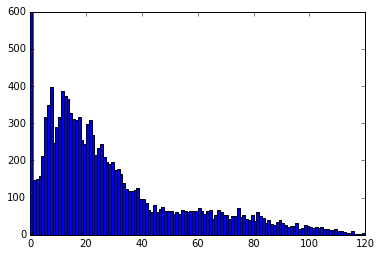

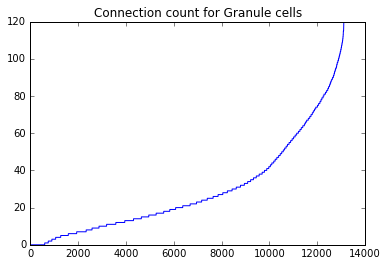

In [41]:
so = con_per_cell (src_fake, int(max(src_fake))+1)
to = con_per_cell (tar_fake, int(max(tar_fake))+1)

plt.figure()
_ = plt.hist(so, int(max(so)))

plt.figure()
plt.plot(np.sort(so))
plt.title ('Connection count for Granule cells')

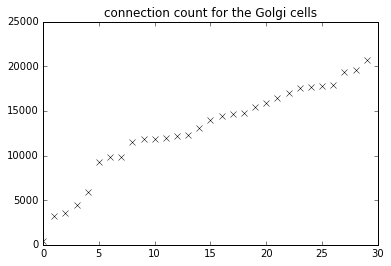

In [42]:
to = con_per_cell (tar_fake,  int(max(tar_fake))+1)

plt.plot(np.sort(to), 'kx')
plt.title('connection count for the Golgi cells')

In [43]:
def plot_point_count_stats (coords, counts, idx = -1, D3 = True, D2 = True):
    norm = mpl.colors.Normalize(vmin=0, vmax=max(counts))
    cmap = cm.hot
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    rgb = m.to_rgba(counts)
    
    if type(idx)=='int': 
        if idx<0 : idx = np.arange(len(counts))
    
    if D3:
        plt.figure(figsize = (15,12))
        ax = plt.gcf().gca(projection='3d')
        ax.scatter(coords[idx,0], coords[idx,1], coords[idx,2], depthshade = False, facecolors = rgb[idx], s  = 40)
        plt.show()
    
    if D2:
        plt.figure(figsize=(21,7))
        for i, [j, k, tit] in enumerate([[0,1, 'x-y plane'], [1,2, 'y-z plane'], [0,2, 'x-z plane']]):

            plt.subplot(1,3,i+1)

            plt.scatter(coords[idx,j], coords[idx,k], facecolors = rgb[idx], s  = 30)
            #plt.axis('equal')

            if False:
                if i in [0,2]: plt.xlim([-100, 500])
            plt.title (tit)

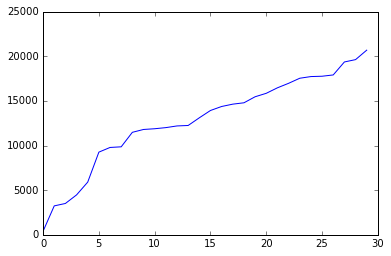

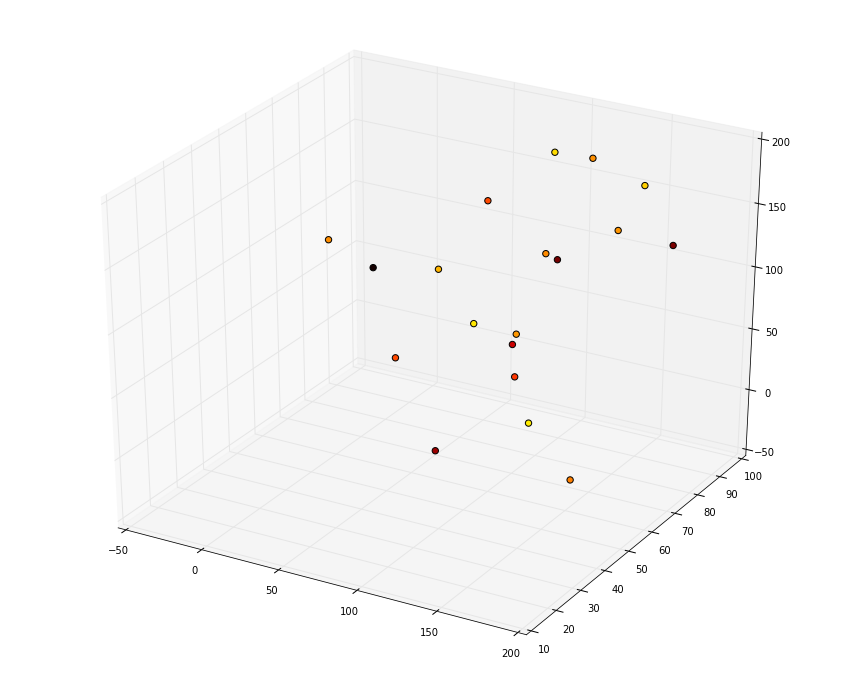

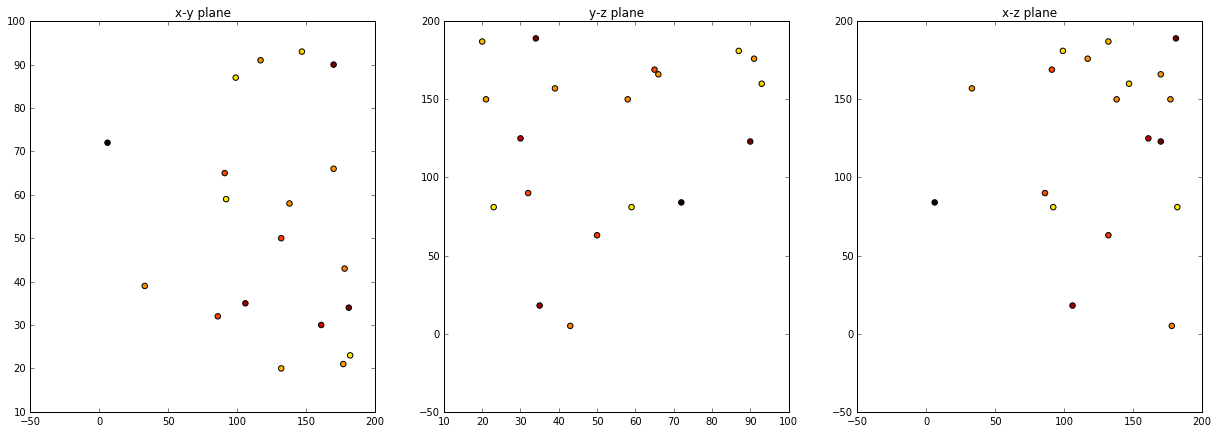

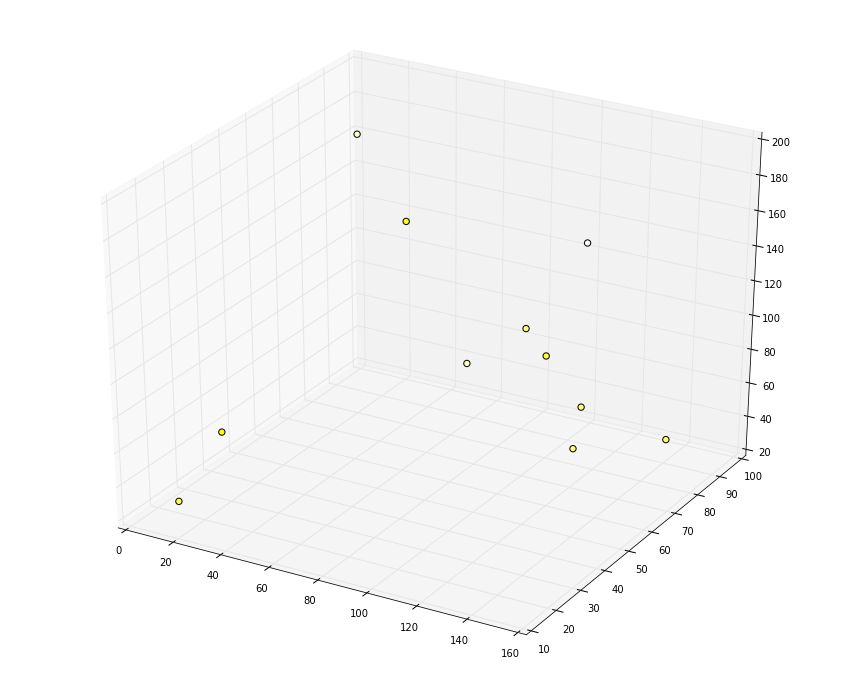

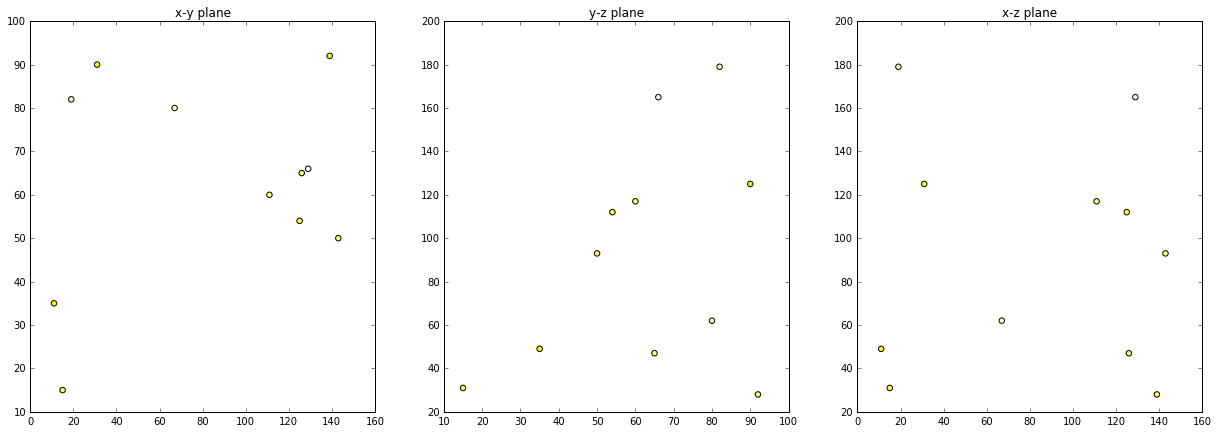

In [44]:
plt.plot(np.sort(to))

idx_l = to<15000
idx_h = to>15000

plot_point_count_stats(goco_f, to, idx_l)
plot_point_count_stats(goco_f, to, idx_h)

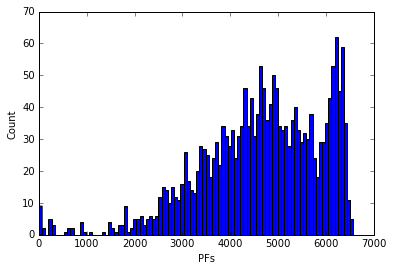

In [35]:
fig, ax = plt.subplots(nrows=1,ncols=1)
_ = ax.hist(count_pf_to_goc, 100)
_ = ax.set(xlabel="PFs", ylabel="Count")

### Distance Files

In [ ]:
filename = 'example_simulation/data/AxontoGoC.bin'
dsize = get_all_data_size(filename) # first we read the data size (number of cells, etc.)
pfs, gocs, _ = read_neuron_vectors(filename, dsize) # and read the data
pfs = pfs.astype(int)

In [ ]:
do_aa = read_in_coordfile('Output_default/output_full_def/AAtoGoCdistances.dat')
do_pf = read_in_coordfile('Output_default/output_full_def/PFtoGoCdistances.dat')

#do_pf = read_in_coordfile('Output_default/output_16/PFtoGoCdistances.dat')


titles = ['AA', 'PF']
for n, do in enumerate([do_aa, do_pf]):
    print (do.shape)
    print (max(do))
    print (min(do))
    plt.figure()
    #plt.plot(np.log(np.diff(np.sort(do.ravel()))))
    plt.plot(np.sort(do.ravel()))
    plt.figure()
    _ = plt.hist(do, 250)


### Segment Files

In [6]:
#pa = 'Output_default/Dendrite_checking_output1/'
pa = ''

goc = read_in_coordfile(pa+'GoCcoordinates.sorted.dat')
grc = read_in_coordfile(pa+'GCcoordinates.sorted.dat')
grt = read_in_coordfile(pa+'GCTcoordinates.sorted.dat')
sor_aa = read_in_coordfile(pa+'AAtoGoCsources.dat')
tar_aa = read_in_coordfile(pa+'AAtoGoCtargets.dat')
sor_pf = read_in_coordfile(pa+'PFtoGoCsources.dat')
tar_pf = read_in_coordfile(pa+'PFtoGoCtargets.dat')
so_aa= read_in_coordfile(pa+'AAtoGoCsegments.dat')
so_pf= read_in_coordfile(pa+'PFtoGoCsegments.dat')
do_aa= read_in_coordfile(pa+'AAtoGoCdistances.dat')
do_pf= read_in_coordfile(pa+'PFtoGoCdistances.dat')

a_dend = read_in_coordfile(pa+'GoCadendcoordinates.sorted.dat')
b_dend = read_in_coordfile(pa+'GoCbdendcoordinates.sorted.dat')

In [7]:
#so_aa= read_in_coordfile('Output_default/output_full_def/AAtoGoCsegments.dat')
#so_pf= read_in_coordfile('Output_default/output_full_def/PFtoGoCsegments.dat')

dist_info = True

titles = ['AA', 'PF']
dis_f = [do_aa, do_pf]
for n, so in enumerate([so_aa, so_pf]):
    fc = so[:,0]
    sc = so[:,1]
    print (titles[n], ':', len(so))
    print ('First')
    for i in np.unique(fc):
        idx = np.isclose(fc, i)
        if dist_info: print (i, ': n =', sum(idx), ', corresponding mean distance:', np.mean(dis_f[n][idx]))
        else: print (i, ': n =', sum(idx))
    print ('Second')
    for i in np.unique(sc):
        idx = np.isclose(sc, i)
        if dist_info: print (i, ': n =', sum(idx), ', corresponding mean distance:', np.mean(dis_f[n][idx]))
        else: print (i, ': n =', sum(idx))

'''titles = ['AA', 'PF']

for n, so in enumerate([so_aa, so_pf]):
    print (so.shape)
    fc = so[:,0]
    sc = so[:,1]
    print (titles[n], ':', len(so))
    print ('First')
    for i in np.unique(fc):
        idx = np.isclose(fc, i)
        print (i, ': n =', sum(idx))
    print ('Second')
    for i in np.unique(sc):
        idx = np.isclose(sc, i)
        print (i, ': n =', sum(idx))'''


AA : 1055
First
1.0 : n = 196 , corresponding mean distance: 17.2854334392
2.0 : n = 198 , corresponding mean distance: 59.9852412524
3.0 : n = 192 , corresponding mean distance: 108.283656402
4.0 : n = 188 , corresponding mean distance: 168.3546766
5.0 : n = 204 , corresponding mean distance: 211.441224726
6.0 : n = 77 , corresponding mean distance: 226.769573578
Second
1.0 : n = 556 , corresponding mean distance: 119.430166889
2.0 : n = 499 , corresponding mean distance: 124.044605554
PF : 3470
First
1.0 : n = 105 , corresponding mean distance: 252.310519482
2.0 : n = 377 , corresponding mean distance: 270.421537191
3.0 : n = 680 , corresponding mean distance: 309.378093662
4.0 : n = 979 , corresponding mean distance: 327.433961526
5.0 : n = 1329 , corresponding mean distance: 367.044075443
Second
2.0 : n = 3470 , corresponding mean distance: 330.59886235


"titles = ['AA', 'PF']\n\nfor n, so in enumerate([so_aa, so_pf]):\n    print (so.shape)\n    fc = so[:,0]\n    sc = so[:,1]\n    print (titles[n], ':', len(so))\n    print ('First')\n    for i in np.unique(fc):\n        idx = np.isclose(fc, i)\n        print (i, ': n =', sum(idx))\n    print ('Second')\n    for i in np.unique(sc):\n        idx = np.isclose(sc, i)\n        print (i, ': n =', sum(idx))"

(1000, 60)
[ 5.26315789  5.26315789  5.26315789  5.26315789  5.26315789  5.26315789
  5.26315789  5.26315789  5.26315789  5.26315789  5.26315789  5.26315789
  5.26315789  5.26315789  5.26315789  5.26315789  5.26315789  5.26315789
  5.26315789]


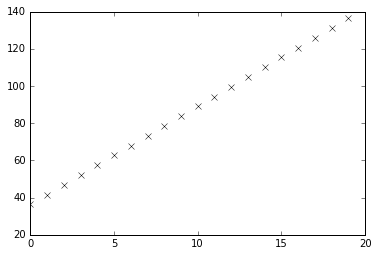

In [8]:
print (a_dend.shape)
zc = np.arange(len(a_dend[1])/3)*3+2
zc = zc.astype('int')
plt.plot(a_dend[1,zc], 'kx')

print (np.diff(a_dend[1,zc]))


[ 1.37579653] [ 346.30634607]
95
-4.75857147369 11.7536820937 -0.404857936073
99
-13.6675729972 36.8306345114 -0.37109252063
97
-21.0694575566 62.2576065299 -0.338423828523
83
-28.2790881101 87.6208968794 -0.322743650398
105
-35.6387154768 112.969887951 -0.315470928787
77
-41.8534776547 134.952862971 -0.310134047795


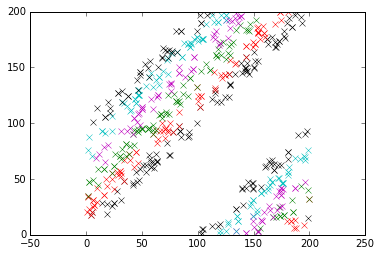

In [53]:
cc = ['kx', 'rx', 'gx', 'mx', 'cx']

if True:
    so, do, sor, tar = so_aa, do_aa, sor_aa, tar_aa
else:
    so, do, sor, tar = so_pf, do_pf, sor_pf, tar_pf 
    
print (min(do_aa), max(do_aa))



for i in np.unique(so[:,0]).astype('int'):
    #idx = so[:,0] == i 
    idx = np.logical_and(so[:,0]== i, so[:,1] == 1.0)
    print (sum(idx))
    if len(idx)>0:
        si = sor[idx].ravel().astype('int')
        ti = tar[idx].ravel().astype('int')
        di = do[idx].ravel()

        gri = grc[si]
        goi = goc[ti]

        #gri = grt[np.logical_and([so[:,1] == 1.0], idx)]
        #goi = got[np.logical_and([so[:,1] == 1.0], idx)]

        #for the parallel fiber
        #plt.plot(np.linalg.norm(gri- goi, axis = 1), di, cc[(i-1)%len(cc)])
        
        #plt.plot(np.sign(gri[:,2] - goi[:,2])*np.linalg.norm(gri- goi, axis = 1), di, cc[(i-1)%len(cc)])

        #plt.plot(np.linalg.norm(gri- goi, axis = 1) - di, cc[(i-1)%len(cc)])
        dif = np.linalg.norm(gri[:,:2]- goi[:,:2], axis = 1)- di
        
        #plt.plot(np.mean(dif[dif>-100]), cc[(i-1)%len(cc)])
        difm = np.mean(dif[dif>-100])
        dim = np.mean(di[dif>-100])
        print (difm, dim, difm/dim)
        
        alpha = np.pi/4
        
        d = np.linalg.norm((gri-goi)[:,[0,1]], axis = 1)
        #d = np.sqrt (gri)
        lpp  = d*np.tan(alpha)
        lp = gri[:,2]- goi[:,2]
        
        di_pred = lpp - lp
        
        #plt.plot(di_pred, di, cc[(i-1)%len(cc)]) 
        plt.plot(goi[:,2], gri[:,2], cc[(i-1)%len(cc)])
        #plt.plot(np.linalg.norm(gri[:,:2]- goi[:,:2], axis = 1)- di, cc[(i-1)%len(cc)])

        #for aa
        #plt.plot(gri[:,0]- goi[:,0], di, cc[(i-1)%len(cc)])
        #plt.plot(gri[:,2]- goi[:,2], di, cc[(i-1)%len(cc)])
        #plt.plot(goi[:,2], di, cc[i-2])

        #mm = np.argmax(di)
        #print (grt[si[mm],2] - goc[ti[mm],2])

        plt.axis('equal')
        #plt.plot(goi[:,0], di, 'xr')
    
#plt.figure()

#plt.ylim((-100,50))

#plt.plot(np.sqrt(cx[:,0]**2 + cx[:,1]**2), cx[:,2])

In [54]:
so_aa= read_in_coordfile('Output_default/output_full_def/AAtoGoCsegments.dat')
so_pf= read_in_coordfile('Output_default/output_full_def/PFtoGoCsegments.dat')


titles = ['AA', 'PF']
dis_f = [do_aa, do_pf]
for n, so in enumerate([so_aa, so_pf]):
    fc = so[:,0]
    sc = so[:,1]
    print (titles[n], ':', len(so))
    print ('First')
    for i in np.unique(fc):
        idx = np.isclose(fc, i)
        print (i, ': n =', sum(idx), ', corresponding mean distance:', np.mean(dis_f[n][idx]))
    print ('Second')
    for i in np.unique(sc):
        idx = np.isclose(sc, i)
        print (i, ': n =', sum(idx), ', corresponding mean distance:', np.mean(dis_f[n][idx]))



AA : 127075
First


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1055 but corresponding boolean dimension is 127075

In [41]:
np.tan(1/4*np.pi)

0.99999999999999989

In [ ]:
comment ='''
    (pf-length . 100)
    (pf-step   . 30)
    (aa-length . 200)
    (aa-step   . 100)
    (z-extent . 200.)
    (y-extent . 700.)
    (x-extent . 1500.)
    (num-gc . 10000) ;798000
    (num-goc . 1000) ;1995
    (mean-goc-distance . 50)
    (goc-grid-xstep . 200)
    (goc-grid-ystep . 500)
    (pf-goc-zone . 5)
    (aa-goc-zone . 5)
    (goc-goc-zone . 30)
    (goc-goc-gap-zone . 30)
    (goc-dendrites . 8) ;4

    (goc-apical-nseg . 4) ;2
    (goc-basolateral-nseg . 9) ;2
    (goc-apical-nsegpts . 1) ;4
    (goc-basolateral-nsegpts . 1) ;4'''
    
np.save('comment.txt', comment)


In [ ]:
a = np.zeros(3)
print (type(a))
print (type(a) == 'numpy.ndarray')
type(a).__module__ == np.__name__



In [55]:
 c2 = read_in_coordfile('teeeeest_GCTcoordinates.dat')

In [56]:
print (c2)

[[ 163.   44.  422.]
 [  18.   89.  231.]
 [ 186.    3.  412.]
 ..., 
 [ 186.   33.  403.]
 [  89.   76.  353.]
 [ 144.   49.  332.]]
